# Batch Inferencing Service в Azure ML

Цель лабораторной работы: 

- развертывание обученной ML модели, как __web-сервиса, работающего в пакетном режиме__ (Batch Inferencing Service)
- подключение и получение прогнозов от web-сервиса, работающего в пакетном режиме.


В предыдущих лабораторных работах мы использовали Конвейер машинного обучения для автоматизации обучения, а также web-сервисы Azure ML для вывода в режиме реального времени результатов прогноза модели.
В рамках этой лабораторной работы мы объединим эти концепции и создадим Конвейер машинного обучения для пакетного вывода результатов прогнозов модели.

Представьте себе, что медицинская клиника проводит измерения пациентов в течение всего дня, сохраняя детали для каждого пациента в отдельном файле. Затем в течение ночи модель машинного обучения обрабатывает собранные данные и делает прогнозы по пациентам, которые подвержены риску развития диабета, чтобы с утра врачи клиники уже имели нужные данные.
Давайте реализуем описанную функциональность в данной лабораторной работе.


## Подготовка среды

Импорт необходимых модулей и проверка версии AzureML SDK:

In [2]:
import os
import pandas as pd

import azureml.core
from azureml.core import Workspace, Model, Environment, Experiment, ComputeTarget, Datastore, Dataset
from azureml.widgets import RunDetails

# Check core SDK version number
print(f'SDK version: {azureml.core.VERSION}')

SDK version: 1.14.0


Получим конфигурацию эксперимента: 

Зададим параметры Эксперимента:

In [4]:
%run core.py

config = get_experiment_config('lab_7B')
init_experiment(config)
experiment_dir = get_experiment_dir(config)

config

Experiment batch-service-experiment was initialized successfully.


{'experiment_name': 'batch-service-experiment',
 'working_subdir': 'batch-service-experiment-lab',
 'service_name': 'diabetes-predict-service',
 'core': {'expriments_root_dir': 'experiments/',
  'datastore_name': 'aml_ws_datastore_v2',
  'dataset_name': 'diabetes-data',
  'ml_cluster_name': 'aml-ws-cluster',
  'ml_model_name': 'diabetes-predict-model'}}

## Соединение со Azure ML Workspace

Устанавливаем соединение с Рабочей областью в Azure ML:

In [5]:
ws = Workspace.from_config()
print(f'Successfully connected to Workspace: {ws.name}.')

Successfully connected to Workspace: aml-workshop.


## Подготовка к развертыванию сервиса пакетной обработки

### Получение ML модели

Получим список уже обученных и зарегистрированных в Azure ML моделей машинного обучения:

In [6]:
for model in Model.list(ws):
    print(f'{model.name} v{model.version}')
    
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print(f'\t {tag_name}: {tag}')
        
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print(f'\t {prop}: {prop_name}')
        
    print('\n')

diabetes-predict-model v3
	 Lab: 5A


diabetes-predict-model v2
	 Lab: 5B
	 0.8576173518134779: AUC
	 0.787: Accuracy


diabetes-predict-model v1
	 Lab: 4B
	 0.8576982541474856: AUC
	 0.7876666666666666: Accuracy




Выберем ML модель, которую хотим развернуть как web-сервис (по умолчанию берется последняя версия модели):

In [7]:
model = ws.models[config['core']['ml_model_name']]
print(f'{model.name} v{model.version}')

diabetes-predict-model v3


## Скрипт для прогнозов

Создадим скрипт, который содержит методы необходимые для:

- `init()`: инициализации web-сервиса
- `run(mini_batch)`: прогноза на пакетах с новыми данными.


In [8]:
%%writefile scripts/batch_score_model.py

#%% Imprort dependencies
import os
import json
import joblib
import numpy as np

from azureml.core.model import Model


def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment. Join this path with the filename of the model file.
    # It holds the path to the directory that contains the deployed model (./azureml-models/$MODEL_NAME/$VERSION).
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.pkl')
    model = joblib.load(model_path)


def run(mini_batch):
    # This runs for each batch
    results = []

    # process each file in the batch
    for f in mini_batch:
        # Read the comma-delimited data into an array
        data = np.genfromtxt(f, delimiter=',')
        # Reshape into a 2-dimensional array for prediction (model expects multiple items)
        prediction = model.predict(data.reshape(1, -1))
        # Append prediction to results
        results.append("{}: {}".format(os.path.basename(f), prediction[0]))
    
    return results


Writing scripts/batch_score_model.py


Скопируем скрипт в директорию эксперимента:

In [9]:
!cp scripts/batch_score_model.py $experiment_dir
!ls $experiment_dir

batch_score_model.py


### Среда для запуска сервиса пакетной обработки

Создадим Среду с необходимыми зависимостями:

In [10]:
from azureml.core.runconfig import DEFAULT_CPU_IMAGE
from azureml.core.runconfig import CondaDependencies

# Add dependencies required by the model
# - scikit-learn you need for trained model
# - azureml-core and azureml-dataprep[fuse] ypu need to parallel pipeline steps
dependencies = CondaDependencies.create(pip_packages=['scikit-learn','azureml-core','azureml-defaults','azureml-dataprep[fuse]'])

batch_env = Environment(name='batch_service_env')
batch_env.python.conda_dependencies = dependencies
batch_env.docker.enabled = True
batch_env.docker.base_image = DEFAULT_CPU_IMAGE

print('Environment is ready.')

Environment is ready.


### ML кластер для запуска сервиса пакетной обработки

Используем [ранее созданный](05B-compute-targets.ipynb) ML кластер для нашей задачи. Для этого получим список созданных Целевых объектов вычислений, а затем выберем нужный:

In [13]:
for ct in ComputeTarget.list(ws):
    print(ct.name)

aml-compute-vm
aml-designer-cc
aml-ws-cluster


In [12]:
cluster = ComputeTarget(workspace=ws, name=config['core']['ml_cluster_name'])

### Данные 

Сгенерируем множество пакетов из [зарегистрованного в Azure ML ранее](02B-datastores-and-datasets.ipynb) Набора данных. Для этого получим список зарегистрированных Наборов данных, а затем выберем нужный:

In [18]:
for ds in Dataset.get_all(ws):
    print(ds)

MD-aml-designer-pipeline-Tune_Model_Hyperparameters-Trained_best_model-6dc9470c
diabetes-data
diabetes-data-ui


In [20]:
data_ds = ws.datasets.get(config['core']['dataset_name'])
print(f'Used dataset {data_ds.name}: {data_ds.description}')

Used dataset diabetes-data: Diabetes Disease Database


Сгенерируем из полученного на предыдущем шаге набора данных множество пакетов данных:

In [21]:
#%% Generate data sample
data_df = data_ds.to_pandas_dataframe()
data_col = list(set(data_df.columns) - set(['PatientID', 'Diabetic'])) # remove not features (PatientID) and label (Diabetic) fields

n_batches = 128 # Set number of batches
data_sample = data_df[data_col].sample(n=n_batches).values


#%% Create a input dir for store batches
batch_dir = f'{experiment_dir}/input'
os.makedirs(batch_dir, exist_ok=True)


#%% Save each sample as a separate file
print('Saving files..')

for i in range(n_batches):
    path = os.path.join(batch_dir, str(i+1) + '.csv')
    data_sample[i].tofile(path, sep=",")
        
print('All files were saved.')

Saving files..
All files were saved.


In [22]:
#%% Upload the files to the default datastore
print('Uploading files to datastore...')

default_ds = ws.get_default_datastore()
default_ds.upload(src_dir=batch_dir, target_path='diabetes-batch-data', overwrite=True, show_progress=True)


#%% Register a dataset for the input data
batch_data_set = Dataset.File.from_files(path=(default_ds, 'diabetes-batch-data/'), validate=False)
try:
    batch_data_set = batch_data_set.register(workspace=ws, 
                                             name='diabetes-batch-data',
                                             description='Diabetes data for Batch Inferencing',
                                             create_new_version=True)
except Exception as ex:
    print(ex)

print('All files were uploaded.')

Uploading files to datastore...
Uploading an estimated of 128 files
Uploading experiments/batch-service-experiment-lab/input/1.csv
Uploaded experiments/batch-service-experiment-lab/input/1.csv, 1 files out of an estimated total of 128
Uploading experiments/batch-service-experiment-lab/input/10.csv
Uploaded experiments/batch-service-experiment-lab/input/10.csv, 2 files out of an estimated total of 128
Uploading experiments/batch-service-experiment-lab/input/100.csv
Uploaded experiments/batch-service-experiment-lab/input/100.csv, 3 files out of an estimated total of 128
Uploading experiments/batch-service-experiment-lab/input/101.csv
Uploaded experiments/batch-service-experiment-lab/input/101.csv, 4 files out of an estimated total of 128
Uploading experiments/batch-service-experiment-lab/input/102.csv
Uploaded experiments/batch-service-experiment-lab/input/102.csv, 5 files out of an estimated total of 128
Uploading experiments/batch-service-experiment-lab/input/103.csv
Uploaded experimen

## Создание и запуск ML Конвейера

Чтобы использовать ML Конвейер для запуска сценария пакетного прогнозирования, необходимо использовать `ParallelRunStep`, который позволяет обрабатывать пакетные данные параллельно и записывать результаты в одном выходном файле с именем `parallel_run_step.txt`.

In [24]:
from azureml.pipeline.core import Pipeline
from azureml.pipeline.core import Pipeline, PipelineData
from azureml.pipeline.steps import ParallelRunConfig, ParallelRunStep


pipeline_output_dir = 'diabetes/outputs'
output_dir = PipelineData(name='batch_inferences_pipe', 
                          datastore=ws.get_default_datastore(), 
                          output_path_on_compute=pipeline_output_dir)


run_config = ParallelRunConfig(
    source_directory=experiment_dir,
    entry_script='batch_score_model.py',
    mini_batch_size='8',
    error_threshold=2,
    output_action='append_row',
    environment=batch_env,
    compute_target=cluster,
    node_count=2
)

batch_score_step = ParallelRunStep(
    name='batch-score',
    parallel_run_config=run_config,
    inputs=[batch_data_set.as_named_input('data')],
    output=output_dir,
    arguments=[],
    allow_reuse=True
)

print('Steps were defined.')

pipeline = Pipeline(workspace=ws, steps=[batch_score_step])

Steps were defined.


Запустим Конвейер:

In [ ]:
pipeline_run = Experiment(ws, config['experiment_name']).submit(pipeline)
pipeline_run.wait_for_completion(show_output=True)

Просмотрите детали выполнения Конвейера на портале Azure ML:

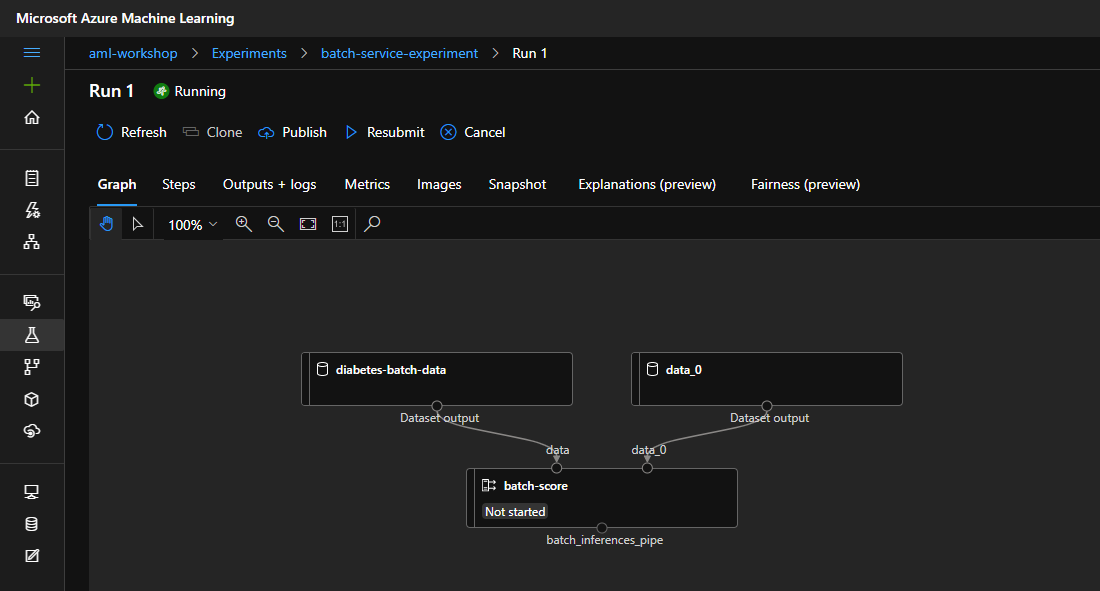

## Публикация ML Конвейера как REST-сервиса

In [ ]:
pipeline = pipeline_run.publish_pipeline(
    name=config['service_name'], 
    description='Batch Scoring Pipeline of Diabetes Data', version='1.0'
)

pipeline

Получим URI Конечной точки созданного REST-сервиса:

In [ ]:
endpoint = pipeline.endpoint
print(endpoint)

## Подключение и взаимодействие с REST-сервисом

Сформируем авторизационный заголовок для отправки запроса к сервису:

In [29]:
from azureml.core.authentication import InteractiveLoginAuthentication

interactive_auth = InteractiveLoginAuthentication()
auth_header = interactive_auth.get_authentication_header()

print('Authentication is header ready.')

Authentication is header ready.


Отправим запрос к сервису и получим id запроса:

In [ ]:
import requests

response = requests.post(endpoint, 
                         headers=auth_header, 
                         json={'ExperimentName': config['experiment_name']})

run_id = response.json()['Id']
run_id

Посмотрим детали запуска во аремя выполнения Эксперимента:

In [ ]:
from azureml.pipeline.core.run import PipelineRun

pipeline_run = PipelineRun(ws.experiments[config['experiment_name']], run_id)
RunDetails(pipeline_run).show()

Просмотрите детали выполнения запроса, используя виджет `RunDetails` или портал Azure ML.

## Результаты прогноза

Когда Конвейер завершит работу, прогнозы ML модели будут сохранены в выходных данных эксперимента. Вы можете получить их следующим образом:

In [ ]:
import shutil

shutil.rmtree(pipeline_output_dir, ignore_errors=True)

prediction_run = next(published_pipeline_run.get_children())
prediction_output = prediction_run.get_output_data(output_dir.name)
prediction_output.download(local_path=pipeline_output_dir)


for root, dirs, files in os.walk(pipeline_output_dir):
    for file in files:
        if file.endswith('parallel_run_step.txt'):
            result_file = os.path.join(root,file)

# cleanup output format
df = pd.read_csv(result_file, delimiter=':', header=None)
df.columns = ['File', 'Prediction']

# Display the first 20 results
df.head(20)

## Полезные ссылки

1. https://docs.microsoft.com/ru-ru/azure/machine-learning/how-to-deploy-and-where?tabs=azcli
2. https://docs.microsoft.com/ru-ru/azure/machine-learning/how-to-deploy-and-where?tabs=azcli#choose-a-compute-target 